In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torch.utils.data as Data
import torchvision.transforms as transforms
import time # 导入模块
import numpy as np

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride = 1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut =  nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self,x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [3]:
class squeeze(nn.Module):
    def __init__(self):
        super(squeeze, self).__init__()
    def forward(self,x):
        out = x.squeeze()  # squeeze 去除所有item数量为1的维度
        return out

In [4]:
ResNet = nn.Sequential(
    nn.Conv2d(3, 64,kernel_size=3, stride=1, padding=1, bias=False),
    ResidualBlock(64,64, stride=1),
    ResidualBlock(64,64, stride=1),
    ResidualBlock(64,128, stride=2),
    ResidualBlock(128,128, stride=1),
    ResidualBlock(128,256, stride=2),
    ResidualBlock(256,256, stride=1),
    ResidualBlock(256,512, stride=2),
    ResidualBlock(512,512, stride=1),
    nn.AvgPool2d(kernel_size=5),
    squeeze(),  # squeeze 去除所有item数量为1的维度
    nn.Linear(in_features=512,out_features=3)
)

In [5]:
def train_epoch(net, data_loader, device):
    net.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0

    for batch_idx, (data, target) in enumerate(data_loader):
        # print(data)
        # print(target)
        data = data.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()
        output = net(data)
#         print("output", output.shape)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        prediction = torch.argmax(output, 1)
#         print("output", output)
#         print("prediction", prediction)
#         print("target", target)
        correct += (prediction == target).sum().item()
        sample_num += len(prediction)
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

In [6]:
data_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])
])
BATCH_SIZE = 128
train_dataset = ImageFolder("vehicle_dataset_new/training_dataset",transform = data_transform)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = ImageFolder("vehicle_dataset_new/test_dataset",transform = data_transform)
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_dataset))
print(len(test_dataset))
print(train_dataset[0][0].size())
print(train_dataset.class_to_idx)
print(test_dataset[0][0].size())
print(test_dataset.class_to_idx)

962
340
torch.Size([3, 64, 64])
{'bus': 0, 'car': 1, 'truck': 2}
torch.Size([3, 64, 64])
{'bus': 0, 'car': 1, 'truck': 2}


In [7]:
num_classes = 3
epochs = 20
lr = 0.001
device = torch.device('cpu')
# device = torch.device('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNet.parameters(), lr = lr)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
training_time_list = []
for epoch in range(epochs):
    print("开始训练------" + str(epoch) + "-------------")

    start = time.time()  #开始时间
    train_loss, train_acc = train_epoch(ResNet, data_loader=train_loader, device=device)
    end = time.time()  #结束时间
    test_loss, test_acc = 0, 0
    test_loss, test_acc  = test_epoch(ResNet, data_loader=test_loader, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    training_time_list.append(end - start)
    print(f"epoch:{epoch}\t train_loss:{train_loss:.4f} \t"
          f"train_acc: {train_acc:.4f} \t"
          f"test_loss: {test_loss:.4f} \t test_acc: {test_acc:.4f} \t training_time: {end-start:.2f}")

开始训练------0-------------
epoch:0	 train_loss:1.2872 	train_acc: 0.5904 	test_loss: 2.6954 	 test_acc: 0.1618 	 training_time: 71.59
开始训练------1-------------
epoch:1	 train_loss:0.5404 	train_acc: 0.7973 	test_loss: 7.5591 	 test_acc: 0.3088 	 training_time: 68.98
开始训练------2-------------
epoch:2	 train_loss:0.4376 	train_acc: 0.8378 	test_loss: 2.4373 	 test_acc: 0.4824 	 training_time: 69.02
开始训练------3-------------
epoch:3	 train_loss:0.3713 	train_acc: 0.8472 	test_loss: 0.4745 	 test_acc: 0.8353 	 training_time: 68.74
开始训练------4-------------
epoch:4	 train_loss:0.3411 	train_acc: 0.8701 	test_loss: 0.4987 	 test_acc: 0.8176 	 training_time: 69.28
开始训练------5-------------
epoch:5	 train_loss:0.3054 	train_acc: 0.8742 	test_loss: 0.4104 	 test_acc: 0.8412 	 training_time: 69.78
开始训练------6-------------
epoch:6	 train_loss:0.2939 	train_acc: 0.8909 	test_loss: 0.7872 	 test_acc: 0.7706 	 training_time: 69.40
开始训练------7-------------
epoch:7	 train_loss:0.2677 	train_acc: 0.9033 	test

In [8]:
for epoch in range(epochs):
    print("开始训练------" + str(epoch) + "-------------")

    start = time.time()  #开始时间
    train_loss, train_acc = train_epoch(ResNet, data_loader=train_loader, device=device)
    end = time.time()  #结束时间
    test_loss, test_acc = 0, 0
    test_loss, test_acc  = test_epoch(ResNet, data_loader=test_loader, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    training_time_list.append(end - start)
    print(f"epoch:{epoch}\t train_loss:{train_loss:.4f} \t"
          f"train_acc: {train_acc:.4f} \t"
          f"test_loss: {test_loss:.4f} \t test_acc: {test_acc:.4f} \t training_time: {end-start:.2f}")

开始训练------0-------------
epoch:0	 train_loss:0.1445 	train_acc: 0.9459 	test_loss: 0.3705 	 test_acc: 0.8706 	 training_time: 68.94
开始训练------1-------------
epoch:1	 train_loss:0.1207 	train_acc: 0.9626 	test_loss: 0.3298 	 test_acc: 0.8882 	 training_time: 68.99
开始训练------2-------------
epoch:3	 train_loss:0.1067 	train_acc: 0.9563 	test_loss: 0.3411 	 test_acc: 0.8853 	 training_time: 68.97
开始训练------4-------------
epoch:4	 train_loss:0.0952 	train_acc: 0.9605 	test_loss: 0.3620 	 test_acc: 0.8765 	 training_time: 68.97
开始训练------5-------------
epoch:5	 train_loss:0.0651 	train_acc: 0.9719 	test_loss: 0.3217 	 test_acc: 0.8941 	 training_time: 69.01
开始训练------6-------------
epoch:6	 train_loss:0.0569 	train_acc: 0.9823 	test_loss: 0.4308 	 test_acc: 0.8676 	 training_time: 69.24
开始训练------7-------------
epoch:7	 train_loss:0.0530 	train_acc: 0.9792 	test_loss: 0.3102 	 test_acc: 0.9118 	 training_time: 69.04
开始训练------8-------------
epoch:8	 train_loss:0.0873 	train_acc: 0.9657 	test

In [9]:
print(train_acc_list)

[0.5904365904365905, 0.7972972972972973, 0.8378378378378378, 0.8471933471933472, 0.8700623700623701, 0.8742203742203742, 0.8908523908523909, 0.9033264033264033, 0.9095634095634095, 0.9085239085239085, 0.896049896049896, 0.896049896049896, 0.9064449064449065, 0.922037422037422, 0.9459459459459459, 0.9386694386694386, 0.9303534303534303, 0.9376299376299376, 0.9542619542619543, 0.946985446985447, 0.9459459459459459, 0.9625779625779626, 0.9667359667359667, 0.9563409563409564, 0.9604989604989606, 0.9719334719334719, 0.9823284823284824, 0.9792099792099792, 0.9656964656964657, 0.9760914760914761, 0.9490644490644491, 0.9501039501039501, 0.9594594594594594, 0.9781704781704782, 0.9802494802494802, 0.9906444906444907, 0.9875259875259875, 0.9896049896049897, 0.9885654885654885, 0.9916839916839917]


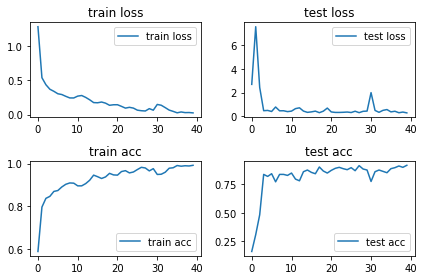

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot(train_loss_list,label,title, subplot):
    ax1 = plt.subplot(subplot)
    plt.plot(list(range(len(train_loss_list))),train_loss_list, label=label)
    ax1.set_title(title)
    ax1.legend()
#     plt.title(title)
#     plt.legend()
#     plt.show()
plot(train_loss_list,"train loss","train loss", 221)
plot(test_loss_list,"test loss","test loss", 222)
plot(train_acc_list,"train acc","train acc", 223)
plot(test_acc_list,"test acc","test acc", 224)
plt.tight_layout()
plt.show()

In [11]:
print(train_loss_list)
print(test_loss_list)
print(train_acc_list)
print(test_acc_list)

[1.2871705815196037, 0.5404373221099377, 0.4375697486102581, 0.3713027611374855, 0.34112206660211086, 0.3053721450269222, 0.2938588634133339, 0.26766442134976387, 0.24421825632452965, 0.24362517334520817, 0.2707857470959425, 0.27948467060923576, 0.25214717350900173, 0.21705567836761475, 0.17598190810531378, 0.1733233043923974, 0.1841593375429511, 0.1676081409677863, 0.13651856500655413, 0.1441438589245081, 0.14451556652784348, 0.12074188468977809, 0.0950296651571989, 0.10667760344222188, 0.09522669203579426, 0.06510751275345683, 0.05689240479841828, 0.052997784689068794, 0.08726318296976388, 0.06464753998443484, 0.14869103953242302, 0.13708128174766898, 0.10255737649276853, 0.0659274565987289, 0.04728473839350045, 0.026268013869412243, 0.03866538216243498, 0.029136331169866025, 0.0304975044564344, 0.02509282744722441]
[2.6954458157221475, 7.559090614318848, 2.4372878074645996, 0.4744510352611542, 0.49868860840797424, 0.41037572423617047, 0.7871576348940531, 0.4659639398256938, 0.470720